In [75]:
import numpy as np
import pandas as pd
import altair as alt
import copy

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable("mimetype")
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable("data_server");

In [76]:
stinson2019 = pd.read_pickle("../data/stinson2019/stinson2019_df")

/home/steffen/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,5,7,9,11,13,15,17,19,21,23,25,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [135]:
stinson2019[stinson2019.site == 'Harvard Forest'].species.

2299    ACRU
2347    ACRU
2395    ACRU
2443    ACRU
2491    ACRU
        ... 
5076    ACSA
5124    ACSA
5172    ACSA
5220    ACSA
5268    ACSA
Name: species, Length: 5299, dtype: object

In [78]:
stinson2019 = stinson2019.sort_values(["site", "tree", "tap", "date"])

# Create unique record ids for each entry in the following form:
# "<TreeID>_<TapID>_<RecordYear>_<ID#>" where ID# is 0 for the first
# record for a given tap in <RecordYear>, 1 is the second ...

# First create "<TreeID>_<TapID>_<RecordYear>_" label for each record_id
stinson2019["record_id"] = (
    +stinson2019["tree"]
    + "_"
    + stinson2019["tap"]
    + "_"
    + pd.DatetimeIndex(stinson2019["year"]).year.astype(str)
    + "_"
)

# Add "<ID#>" to each record_id
for tapyear in stinson2019["record_id"].unique():
    stinson2019.loc[stinson2019["record_id"] == tapyear, "record_id"] += [
        str(i) for i in range(stinson2019[stinson2019["record_id"] == tapyear].shape[0])
    ]

stinson2019["tap_id"] = stinson2019["tree"] + stinson2019["tap"]

# normalize data tables
tap_records = stinson2019[["record_id", "tap_id"]].set_index("record_id")
sap = (
    stinson2019[["record_id", "sap_wt"]]
    .rename(columns={"sap_wt": "sap"})
    .set_index("record_id")
)
sugar = stinson2019[["record_id", "sugar"]].set_index("record_id")
dates = stinson2019[["record_id", "date"]].set_index("record_id")
dates.loc[:, "date"] = pd.to_datetime(dates["date"])
tap_tree = stinson2019[["tap_id", "tree"]].drop_duplicates().set_index("tap_id")
tree_species = stinson2019[["tree", "species"]].drop_duplicates().set_index("tree")
site = stinson2019[["tree", "site"]].drop_duplicates().set_index("tree")
site["site"] = site["site"].str.upper()

In [79]:
stinson2019

,site,date,tree,species,tap,sugar,sap_wt,year,site_id,tree_id,tree_record_id,tap_record_id,record_id,tap_id
5299,Dartmouth Organic Farm,2014-03-11,DOF1,ACSA,A,1.2,0.03,2014-01-01,DOF,DOF.ACSA.DOF1,DOF.ACSA.DOF1.2014-03-11,DOF.ACSA.DOF1.A.2014-03-11,DOF1_A_2014_0,DOF1A
5322,Dartmouth Organic Farm,2014-03-17,DOF1,ACSA,A,NaN,0.01,2014-01-01,DOF,DOF.ACSA.DOF1,DOF.ACSA.DOF1.2014-03-17,DOF.ACSA.DOF1.A.2014-03-17,DOF1_A_2014_1,DOF1A
5345,Dartmouth Organic Farm,2014-03-30,DOF1,ACSA,A,NaN,NaN,2014-01-01,DOF,DOF.ACSA.DOF1,DOF.ACSA.DOF1.2014-03-30,DOF.ACSA.DOF1.A.2014-03-30,DOF1_A_2014_2,DOF1A
5368,Dartmouth Organic Farm,2014-03-31,DOF1,ACSA,A,NaN,0.01,2014-01-01,DOF,DOF.ACSA.DOF1,DOF.ACSA.DOF1.2014-03-31,DOF.ACSA.DOF1.A.2014-03-31,DOF1_A_2014_3,DOF1A
5391,Dartmouth Organic Farm,2014-04-01,DOF1,ACSA,A,2.2,0.67,2014-01-01,DOF,DOF.ACSA.DOF1,DOF.ACSA.DOF1.2014-04-01,DOF.ACSA.DOF1.A.2014-04-01,DOF1_A_2014_4,DOF1A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7785,Southernmost Maple,2016-02-28,SMAS8,ACSA,B,2.1,15.11,2016-01-01,SMM,SMM.ACSA.SMAS8,SMM.ACSA.SMAS8.2016-02-28,SMM.ACSA.SMAS8.B.2016-02-28,SMAS8_B_2016_3,SMAS8B
7817,Southernmost Maple,2016-02-29,SMAS8,ACSA,B,1.8,9.11,2016-01-01,SMM,SMM.ACSA.SMAS8,SMM.ACSA.SMAS8.2016-02-29,SMM.ACSA.SMAS8.B.2016-02-29,SMAS8_B_2016_4,SMAS8B
7849,Southernmost Maple,2016-03-02,SMAS8,ACSA,B,2.4,10.41,2016-01-01,SMM,SMM.ACSA.SMAS8,SMM.ACSA.SMAS8.2016-03-02,SMM.ACSA.SMAS8.B.2016-03-02,SMAS8_B_2016_5,SMAS8B
7881,Southernmost Maple,2016-03-06,SMAS8,ACSA,B,1.8,17.01,2016-01-01,SMM,SMM.ACSA.SMAS8,SMM.ACSA.SMAS8.2016-03-06,SMM.ACSA.SMAS8.B.2016-03-06,SMAS8_B_2016_6,SMAS8B


In [125]:
def get_weekly_data(
    location=["all"], tree="all", tap_id="all", years="all", species="ACSA"
):
    """Generate data table containing cumulative weekly sap and sugar amounts

    Parameters
    ----------
    location : str or list of str, optional
        Name of locations (sites) to be included in data table, by default 'all'
    tree : str or list of str, optional
        ID of trees to be included in data table, by default 'all'
    tap_id : str or list of str, optional
        ID of taps to be included in data table, by default 'all'
    years : int, list of ints, or 'all' , optional
        Years to be included in data table, by default 'all'
    species : str, list of str, or 'all' , optional
        Species to be included in data table, by default 'ACSA' (sugar maple)

    Returns
    -------
    pd.DataFrame
        Table with weekly summaries for all taps specified in arguments.  Includes
        cumulative sap and sugar weight, and weekly sap and sugar weight.
    """
    # Check and clean location argument
    if type(location) != list:
        location = [location]
    location = [x.upper() for x in location]
    if location == ["ALL"]:
        location = site["site"].unique().tolist()

    # Check and clean tap_id argument
    if type(tap_id) != list:
        tap_id = [tap_id]
    tap_id = [x.upper() for x in tap_id]
    if tap_id == ["ALL"]:
        tap_id = tap_tree.index.tolist()

    # Check and clean tree argument
    if type(tree) != list:
        tree = [tree]
    tree = [x.upper() for x in tree]
    if tree == ["ALL"]:
        tree = tap_tree["tree"].unique().tolist()

    # Check and clean years argument
    if type(years) != list:
        years = [years]
    if type(years[0]) == str:
        years[0] = years[0].upper()
        if years == ["ALL"]:
            years = pd.DatetimeIndex(dates["date"]).year.unique().tolist()

    # Check and clean species argument
    if type(species) != list:
        species = [species]
    species = [x.upper() for x in species]
    if species == ["ALL"]:
        species = tree_species["species"].unique().tolist()

    tap_id = (
        tap_tree[tap_tree.index.isin(tap_id)]
        .join(site, how="left", on="tree")
        .reset_index()
        .merge(tree_species, how="left", on="tree")
        .set_index("tap_id")
    )
    tap_id = tap_id[
        (tap_id["tree"].isin(tree))
        & (tap_id["site"].isin(location))
        & (tap_id["species"].isin(species))
    ].index.tolist()

    # Initialize summary dataframe
    weekly_df = pd.DataFrame()

    # Create weekly summaries, iterating through all taps
    for tap in tap_id:
        print("tap:  ", tap)
        # Create joint dataframe will all required info for current tap
        df = (
            tap_records.join(tap_tree[tap_tree.index == tap], how="right", on="tap_id")
            .join(sap, how="left")
            .join(sugar, how="left")
            .join(dates[pd.DatetimeIndex(dates["date"]).year.isin(years)], how="inner")
        )
        df["year"] = pd.DatetimeIndex(df["date"]).year
        df["jd"] = pd.DatetimeIndex(df["date"]).dayofyear

        for year in df["year"].unique():
            #             print('     year: ', year)
            df_year = df[df["year"] == year]

            # Deal with multiple entries per day.  Sap taken as sum of measurements, sugar content as weighted average.
            if not df_year["jd"].is_unique:
                df_year_temp = copy.copy(df_year)
                df_year_temp["product"] = df_year_temp.sap * df_year_temp.sugar.fillna(
                    value=df_year_temp.sugar.mean()
                )
                df_year_temp = df_year_temp.groupby(by="jd").sum().reset_index()
                df_year_temp["sugar"] = df_year_temp["product"] / df_year_temp["sap"]
                df_year = df_year.drop_duplicates(subset="jd")
                df_year = (
                    df_year.reset_index()
                    .merge(
                        df_year_temp[["jd", "sap", "sugar"]],
                        on="jd",
                        how="right",
                        suffixes=["", "_sum"],
                    )
                    .set_index("record_id")
                )
                df_year["sap"] = df_year["sap_sum"]
                df_year["sugar"] = df_year["sugar_sum"]
                df_year = df_year.drop(columns=["sap_sum", "sugar_sum"])

            # Add entry for every day of year from first day with recorded flow to last
            df_year = (
                df_year.reset_index()
                .merge(
                    pd.date_range(
                        start=df_year["date"].min(), end=df_year["date"].max()
                    ).to_frame(name="date"),
                    how="right",
                    on="date",
                )
                .set_index("date", drop=False)
            )

            # Assumption: missing sugar content should be filled with mean sugar content
            df_year["sugarwt"] = (
                df_year.sap * df_year.sugar.fillna(value=df_year.sugar.mean()) / 100
            )

            # Assumption: missing sap values should be replaced with zeros
            df_year["cum_sap"] = df_year.sap.fillna(value=0).cumsum()
            df_year["cum_sugarwt"] = df_year.sugarwt.fillna(value=0).cumsum()
            df_year["tap_id"] = df_year.tap_id.fillna(value=tap)
            df_year["tree"] = df_year.tree.fillna(value=df_year.tree[0])
            df_year["year"] = pd.DatetimeIndex(df_year["date"]).year
            df_year["jd"] = pd.DatetimeIndex(df_year["date"]).dayofyear

            for day in df_year.index[6:]:
                if df_year["date"].min() == (day - pd.to_timedelta(6, unit="D")):
                    df_year.loc[day, "weekly_sap"] = df_year.loc[day]["cum_sap"]
                    df_year.loc[day, "weekly_sugarwt"] = df_year.loc[day]["cum_sugarwt"]
                else:
                    df_year.loc[day, "weekly_sap"] = (
                        df_year.loc[day]["cum_sap"]
                        - df_year.loc[day - pd.to_timedelta(7, unit="D")]["cum_sap"]
                    )
                    df_year.loc[day, "weekly_sugarwt"] = (
                        df_year.loc[day]["cum_sugarwt"]
                        - df_year.loc[day - pd.to_timedelta(7, unit="D")]["cum_sugarwt"]
                    )
                    df_year.loc[day, "cum_syrupLitres"] = (
                        df_year.loc[day, "cum_sugarwt"] / 1.33
                    )
                    df_year.loc[day, "weekly_syrupLitres"] = (
                        df_year.loc[day, "weekly_sugarwt"] / 1.33
                    )

            df_year["date_from"] = df_year["date"] - pd.to_timedelta(6, unit="D")
            df_year["date_to"] = df_year["date"]
            df_year["jd_from"] = df_year["jd"] - 6
            df_year["jd_to"] = df_year["jd"]
            df_year = df_year.drop(columns=["date", "jd", "record_id"])

            weekly_df = weekly_df.append(df_year)

    return weekly_df

In [94]:
# %load_ext snakeviz

In [ ]:
# import time
# %snakeviz a = get_weekly_data()
# begin = time.time()
a = get_weekly_data()
# print(f"Process took {(time.time() - begin):.0f} seconds")

In [139]:
a

,tap_id,tree,sap,sugar,year,sugarwt,cum_sap,cum_sugarwt,weekly_sap,weekly_sugarwt,cum_syrupLitres,weekly_syrupLitres,date_from,date_to,jd_from,jd_to
date,,,,,,,,,,,,,,,,
2012-02-16,HF1A,HF1,4.24,2.7,2012,0.11448,4.24,0.11448,NaN,NaN,NaN,NaN,2012-02-10,2012-02-16,41,47
2012-02-17,HF1A,HF1,6.47,2.6,2012,0.16822,10.71,0.28270,NaN,NaN,NaN,NaN,2012-02-11,2012-02-17,42,48
2012-02-18,HF1A,HF1,4.22,2.6,2012,0.10972,14.93,0.39242,NaN,NaN,NaN,NaN,2012-02-12,2012-02-18,43,49
2012-02-19,HF1A,HF1,4.50,2.6,2012,0.11700,19.43,0.50942,NaN,NaN,NaN,NaN,2012-02-13,2012-02-19,44,50
2012-02-20,HF1A,HF1,NaN,NaN,2012,NaN,19.43,0.50942,NaN,NaN,NaN,NaN,2012-02-14,2012-02-20,45,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-01,HF9B,HF9,NaN,NaN,2017,NaN,66.84,1.65336,19.88,0.42636,1.243128,0.320571,2017-03-26,2017-04-01,85,91
2017-04-02,HF9B,HF9,10.14,2.3,2017,0.23322,76.98,1.88658,24.58,0.56710,1.418481,0.426391,2017-03-27,2017-04-02,86,92
2017-04-03,HF9B,HF9,2.94,2.3,2017,0.06762,79.92,1.95420,21.72,0.50132,1.469323,0.376932,2017-03-28,2017-04-03,87,93


In [154]:
b = a.reset_index().merge(site, on='tree', how='left')
b[(b['site']=='DARTMOUTH ORGANIC FARM') & (b['year']==2014)]

,date,tap_id,tree,sap,sugar,year,sugarwt,cum_sap,cum_sugarwt,weekly_sap,weekly_sugarwt,cum_syrupLitres,weekly_syrupLitres,date_from,date_to,jd_from,jd_to,site
0,2014-03-11,DOF1A,DOF1,0.03,1.2,2014,0.000360,0.03,0.000360,NaN,NaN,NaN,NaN,2014-03-05,2014-03-11,64,70,DARTMOUTH ORGANIC FARM
1,2014-03-12,DOF1A,DOF1,NaN,NaN,2014,NaN,0.03,0.000360,NaN,NaN,NaN,NaN,2014-03-06,2014-03-12,65,71,DARTMOUTH ORGANIC FARM
2,2014-03-13,DOF1A,DOF1,NaN,NaN,2014,NaN,0.03,0.000360,NaN,NaN,NaN,NaN,2014-03-07,2014-03-13,66,72,DARTMOUTH ORGANIC FARM
3,2014-03-14,DOF1A,DOF1,NaN,NaN,2014,NaN,0.03,0.000360,NaN,NaN,NaN,NaN,2014-03-08,2014-03-14,67,73,DARTMOUTH ORGANIC FARM
4,2014-03-15,DOF1A,DOF1,NaN,NaN,2014,NaN,0.03,0.000360,NaN,NaN,NaN,NaN,2014-03-09,2014-03-15,68,74,DARTMOUTH ORGANIC FARM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5048,2014-04-19,DOF9B,DOF9,NaN,NaN,2014,NaN,16.00,0.440060,1.96,0.056840,0.330872,0.042737,2014-04-13,2014-04-19,103,109,DARTMOUTH ORGANIC FARM
5049,2014-04-20,DOF9B,DOF9,NaN,NaN,2014,NaN,16.00,0.440060,1.89,0.054810,0.330872,0.041211,2014-04-14,2014-04-20,104,110,DARTMOUTH ORGANIC FARM
5050,2014-04-21,DOF9B,DOF9,10.03,2.6,2014,0.260780,26.03,0.700840,11.92,0.315590,0.526947,0.237286,2014-04-15,2014-04-21,105,111,DARTMOUTH ORGANIC FARM
5051,2014-04-22,DOF9B,DOF9,NaN,NaN,2014,NaN,26.03,0.700840,10.66,0.280310,0.526947,0.210759,2014-04-16,2014-04-22,106,112,DARTMOUTH ORGANIC FARM


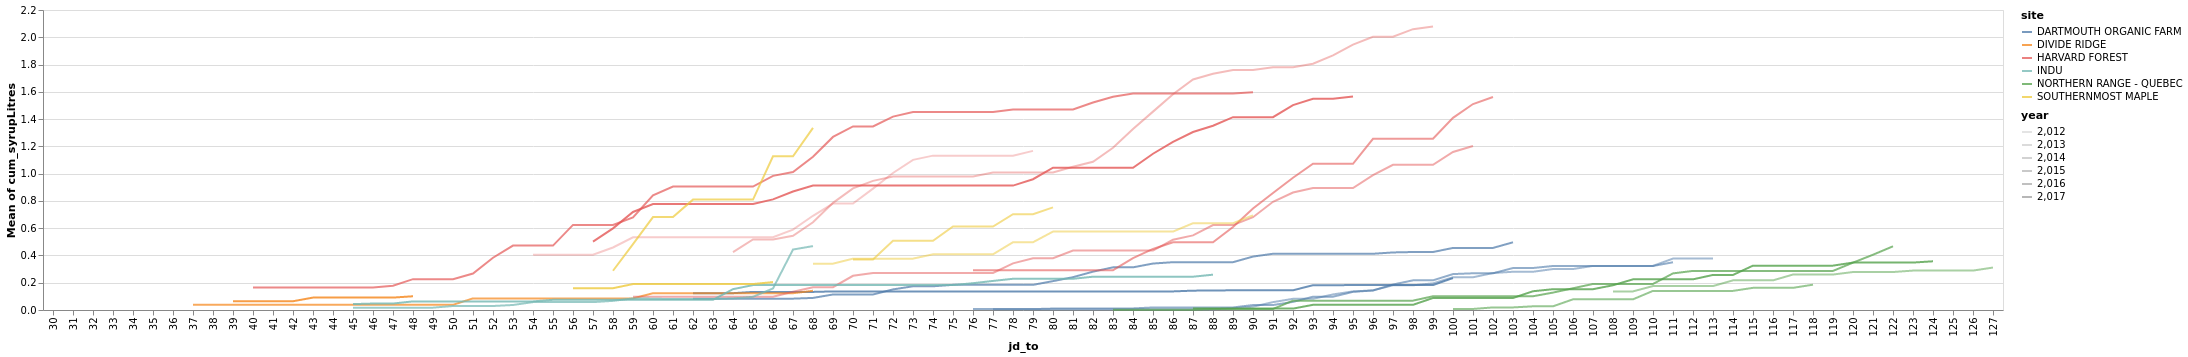

In [158]:
alt.Chart(b).mark_line().encode(
    alt.Y('mean(cum_syrupLitres)'),
    alt.X('jd_to:O'),
    color = 'site:N',
    opacity = 'year'
).interactive()

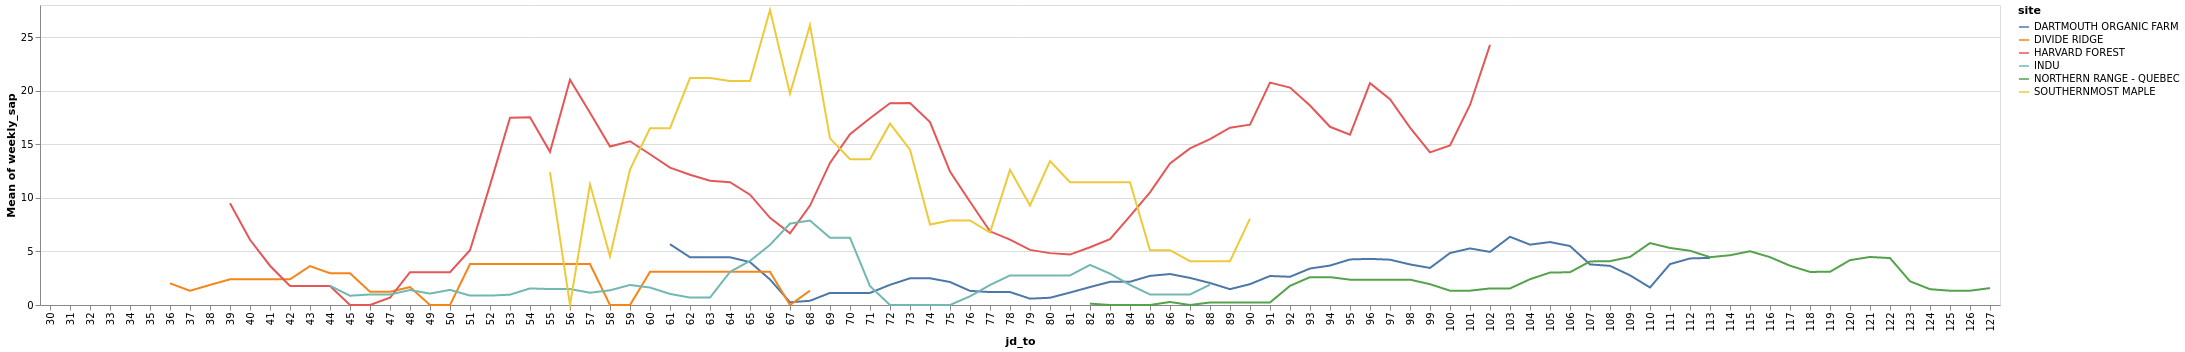

In [144]:
alt.Chart(b).mark_line().encode(
    alt.Y('mean(weekly_sap)'),
    alt.X('jd_to:O'),
    color = 'site',
).interactive()

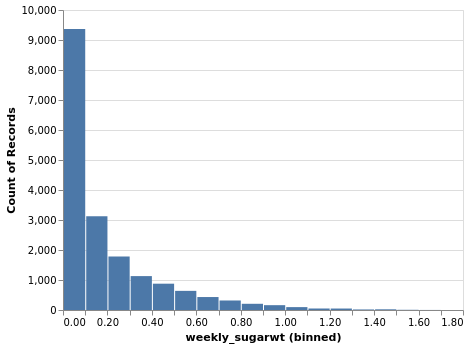

In [145]:
alt.Chart(a).mark_bar().encode(
    alt.X('weekly_sugarwt',bin=alt.Bin(maxbins=30)),
    alt.Y('count()')
)